In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [49]:
embedding_dim = 8
max_number = 100
base = 10

#Random embeddings (CONTROL)
random_embedding = nn.Embedding(max_number + 1, embedding_dim)
torch.manual_seed(42)
with torch.no_grad():
    random_embedding.weight.copy_(torch.randn_like(random_embedding.weight))



# #Abacus digit-wise embedding
digit_embedding = nn.Embedding(base, embedding_dim)
positional_embedding = nn.Embedding(max_number, embedding_dim)


def abacus_embed(n):
    # digits = [int(d) for d in str(n).zfill(max_number)]
    digits = [int(d) for d in str(n)]
    digit_vecs = digit_embedding(torch.tensor(digits))
    # pos_vecs = positional_embedding(torch.arange(len(digits)))
    pos_vecs = 0

    return (digit_vecs + pos_vecs).sum(dim=0)

In [23]:
# def abacus_embed(number, max_number=max_number, base=base, embedding_dim=embedding_dim, offset=0):

#     #int -> string -> list of digits
#     digits = [int(d) for d in str(number).zfill(max_number)]
    
#     #init matrix
#     embedding = np.zeros((max_number, embedding_dim))
    
#     for i, digit in enumerate(digits):
#         position = offset + i

#         # #One-hot encoding to embedding (PREFERENCE)
#         # one_hot = np.zeros(base)
#         # one_hot[digit] = 1

#         # embedding = np.dot(one_hot, embedding.weight.detach().numpy())

#         #Sinusoidal positional encoding (PREFERENCE)
#         pos_enc = np.array([
#             np.sin(position / (10000 ** (2 * j / embedding_dim))) if j % 2 == 0
#             else np.cos(position / (10000 ** (2 * j / embedding_dim)))
#             for j in range(embedding_dim)
#         ])

#         #
#         #Combine digit value and positional encoding
#         embedding[i] = digit * pos_enc
    
#     return torch.tensor(embedding.flatten(), dtype=torch.float32)


In [50]:
def evaluate_commutativity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            emb_sum = embedding_func(a) + embedding_func(b)
            emb_total = embedding_func(a + b)
            loss += torch.norm(emb_sum - emb_total).item()
    return loss

print("Random Embedding Loss:", evaluate_commutativity(lambda x: random_embedding(torch.tensor(x))))
print("Abacus Embedding Loss:", evaluate_commutativity(abacus_embed))

Random Embedding Loss: 551.965234041214
Abacus Embedding Loss: 557.8741846084595


In [51]:
def evaluate_associativity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            for c in range(0, 11):
                emb_sum = embedding_func(a + b) + embedding_func(c)
                emb_total = embedding_func(a) + embedding_func(b + c)
                loss += torch.norm(emb_sum - emb_total).item()
    return loss

print("Random Embedding Loss:", evaluate_associativity(lambda x: random_embedding(torch.tensor(x))))
print("Abacus Embedding Loss:", evaluate_associativity(abacus_embed))

Random Embedding Loss: 6116.518409729004
Abacus Embedding Loss: 6487.283605413342


In [52]:
def evaluate_distributivity(embedding_func):
    loss = 0
    for a in range(0, 11):
        for b in range(0, 11):
            for c in range(0, 11):
                emb_sum = embedding_func(a) * (embedding_func(b) + embedding_func(c))
                emb_total = embedding_func(a * b) + embedding_func(a * c)
                loss += torch.norm(emb_sum - emb_total).item()
    return loss

print("Random Embedding Loss:", evaluate_distributivity(lambda x: random_embedding(torch.tensor(x))))
print("Abacus Embedding Loss:", evaluate_distributivity(abacus_embed))

Random Embedding Loss: 7920.325818061829
Abacus Embedding Loss: 8965.04811835289


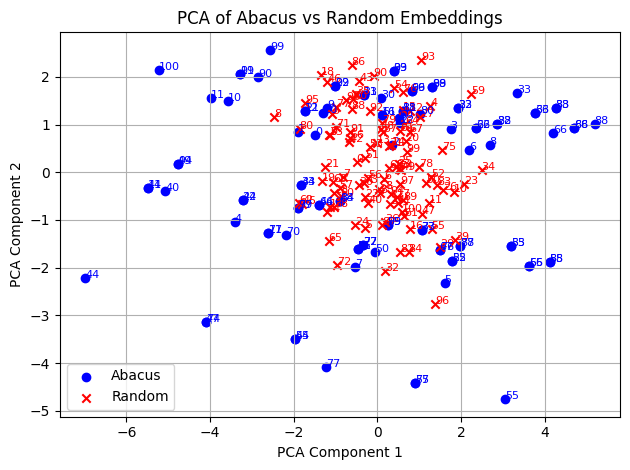

In [53]:
def PCA_plot():
    abacus = np.array([abacus_embed(i).detach().numpy() for i in range(max_number + 1)])
    randoms = np.array([random_embedding(torch.tensor(i)).detach().numpy() for i in range(max_number + 1)])

    combined = np.vstack((abacus, randoms))
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined)
    abacus_2d = reduced[:max_number+1]
    randoms_2d = reduced[max_number+1:]

    plt.scatter(abacus_2d[:, 0], abacus_2d[:, 1], color='blue', label='Abacus')
    plt.scatter(randoms_2d[:, 0], randoms_2d[:, 1], color='red', label='Random', marker='x')

    for i in range(max_number + 1):
        plt.annotate(str(i), xy=(abacus_2d[i, 0], abacus_2d[i, 1]), color='blue', fontsize=8)
        plt.annotate(str(i), xy=(randoms_2d[i, 0], randoms_2d[i, 1]), color='red', fontsize=8)

    plt.title("PCA of Abacus vs Random Embeddings")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

PCA_plot()